In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [77]:
import imageio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar

from src.ImUtils import commonStackReader
from src.Segmentation3D import get_voxel_size_35mm, scale_refractive

In [78]:
# experimental parameters
vox_to_um    = get_voxel_size_35mm()
tomo_scaling = 10_000
n_cell       = 1.38

In [79]:
# import data
dir  = '../../data/Tomocube/MDCK_10.02.2025/A2P1'
file = '250210.113448.MDCK dynamics.001.MDCK B.A2.T001P01_HT3D_0'

stack = commonStackReader(f"{dir}/{file}.tiff")

# scale to mean around 1.38
stack = scale_refractive(stack)

In [80]:
# prepare image data
y_min = 100
y_max = 200
im = np.mean(stack[:, y_min:y_max], axis=1)

# define ROI to enforce equal aspect ratio (in µm)
z_min = 25
z_max = len(im) - z_min
xy_to_z = 1.75

z_range = z_max - z_min
x_range = int(xy_to_z * z_range * vox_to_um[0] / vox_to_um[1])

# cut out ROI
im = im[z_min:z_max, :x_range]

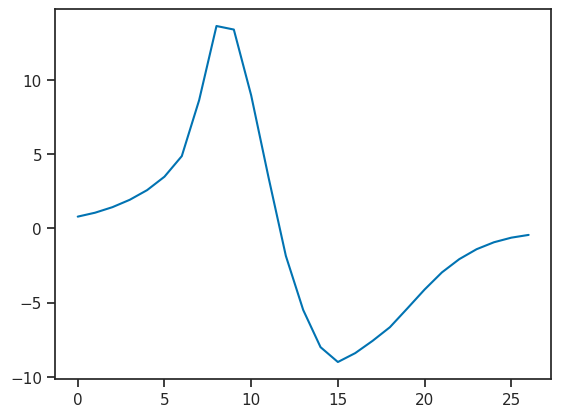

In [65]:
# Prepare lineplot

# cell bottom z-slice
z0 = (34 - z_min) * vox_to_um[0]

# refractive index along z and derivative
n_z   = np.mean(stack[z_min:z_max], axis=(1,2))
dn_dz = np.diff(n_z)

# corresponding z-slices
z_arr  = vox_to_um[0] * np.arange(z_range)
dz_arr = vox_to_um[0] *(np.arange(z_range - 1) + 0.5)
z0_arr = np.ones_like(z_arr) * z0

# line in imshow
z0_im  = np.ones(x_range) * z0
xy_arr = np.arange(0, x_range) * vox_to_um[1]

plt.plot(dn_dz)

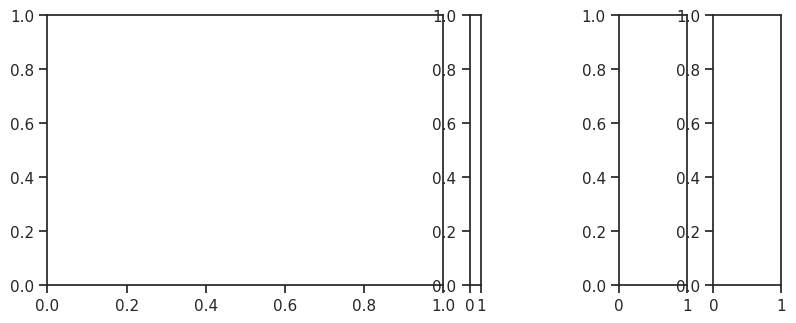

In [72]:
# define figure
w = 12
h = 3.5

#color = "crimson"
width_ratios = [7, 0.2, 1.5, 1.2, 1.2, 3]

# define the GridSpec layout
gs = gridspec.GridSpec(1, 6, width_ratios=width_ratios)
gs.update(wspace=0.2, hspace=0.2)

# create figure
fig = plt.figure(figsize=(w,h))
sns.set_theme(style='ticks', palette='colorblind', font_scale=1)

# create subfigures
imx   = fig.add_subplot(gs[0])
cb    = fig.add_subplot(gs[1])
p0    = fig.add_subplot(gs[3], sharey=imx)
p1    = fig.add_subplot(gs[4], sharey=imx)
# dummy = fig.add_subplot(gs[5])

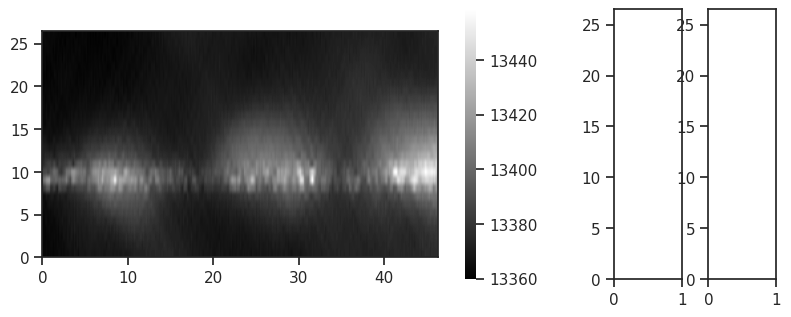

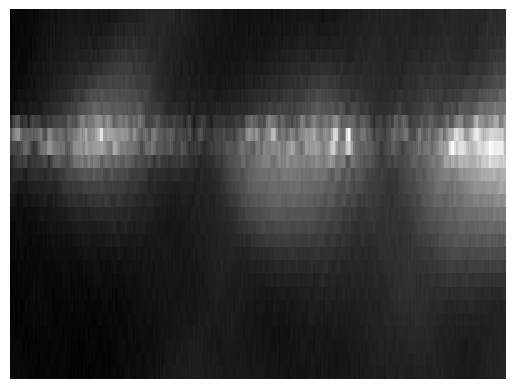

In [73]:
# plot image of output from tomocube
extent = [0, len(im[0]) * vox_to_um[1], 0, len(im) * vox_to_um[0]]

imx.imshow(im, cmap="gray", origin="lower", aspect="equal", extent=extent)
sns.heatmap(im, ax=None, square=False, cmap="gray", xticklabels=False, yticklabels=False, cbar_ax=cb);

fig

In [74]:
p0.plot( n_z,  z_arr,  color="b")
p1.plot(dn_dz, dz_arr, color="b")

p0.hlines(z0, np.min(n_z),   np.max(n_z),   ls="dashed", color="m")
p1.hlines(z0, np.min(dn_dz), np.max(dn_dz), ls="dashed", color="m")

#imx.plot(xy_arr, z0_im, '--',     color="m", alpha=1)

#p0.set(ylim=(z_min, z_max))
#p0.set_yticks([20, 30, 40, 50])
p0.axes.get_xaxis().set_visible(False)
p1.axes.get_xaxis().set_visible(False)
p1.axes.get_yaxis().set_visible(False)

sns.despine(ax=p0)
sns.despine(ax=p1)

/tmp/ipykernel_8037/2730018611.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


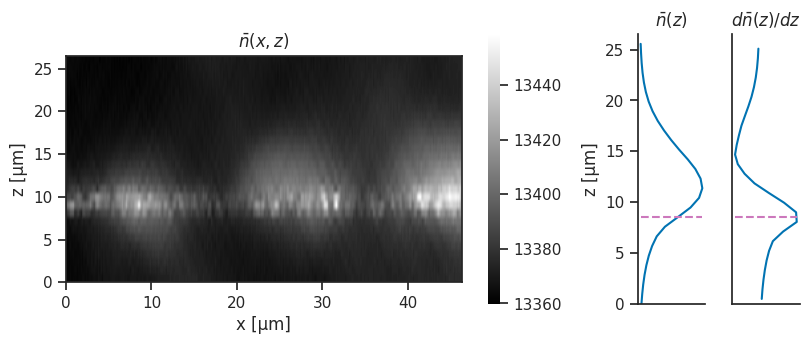

In [75]:
p0.set(title= r"$\bar{n}(z)$", ylabel="z [µm]")
p1.set(title= r"$d\bar{n}(z)/dz$")

imx.set(title =r"$\bar{n}(x,z)$",
        xlabel="x [µm]", 
        ylabel="z [µm]")

fig.tight_layout()
fig

In [51]:
fig.savefig(f"../../figs/illustrations/image_preprocessing_cell_bottom.png", dpi=300)

In [81]:
from src.Segmentation3D import *